# MLFlow

# Headers

In [1]:
import pandas as pd


from main import *

import numpy as np

In [2]:
import os
import pandas as pd
import snowflake.connector
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import lightgbm as lgb
import numpy as np
from matplotlib.ticker import FuncFormatter

# Load Data

In [3]:
df_main = pd.read_csv('/home/azureuser/cloudfiles/code/Users/vlavanga/data/processed/snowflake_v4_pre_ts.csv')
df_main.head()

,PO_CREATED_DATE,SALES_ORG,SALES_ORG_NAME,FABRIC_CONTENT_CODE_TEXT,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,20231003,3200,Japan,100% Cotton woven,Wovens,YOMIURI GIANTS,LP5950,BASEBALL,Headwear,Custom,72
1,20231003,3200,Japan,100% Cotton woven,Wovens,YOMIURI GIANTS,LP5950,BASEBALL,Headwear,Custom,72
2,20231109,4100,New Zealand,Cotton - Woven,Wovens,LAS VEGAS RAIDERS,940,FOOTBALL,Headwear,Program,80
3,20231103,1000,United States,Manmade fibers - Woven,Wovens,RANCHO CUCAMONGA QUAKES,5950,BASEBALL,Headwear,Program,1
4,20231103,1000,United States,Manmade fibers - Woven,Wovens,RENO ACES,5950,BASEBALL,Headwear,Program,1


In [4]:
df_main = df_main.drop(columns=['SALES_ORG', 'FABRIC_CONTENT_CODE_TEXT'])
df_main['PO_CREATED_DATE'] = pd.to_datetime(df_main['PO_CREATED_DATE'], format='%Y%m%d')
df_main.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2023-10-03,Japan,Wovens,YOMIURI GIANTS,LP5950,BASEBALL,Headwear,Custom,72
1,2023-10-03,Japan,Wovens,YOMIURI GIANTS,LP5950,BASEBALL,Headwear,Custom,72
2,2023-11-09,New Zealand,Wovens,LAS VEGAS RAIDERS,940,FOOTBALL,Headwear,Program,80
3,2023-11-03,United States,Wovens,RANCHO CUCAMONGA QUAKES,5950,BASEBALL,Headwear,Program,1
4,2023-11-03,United States,Wovens,RENO ACES,5950,BASEBALL,Headwear,Program,1


In [5]:
df_main['DIVISION_NAME'].unique()

array(['Headwear', 'Apparel', 'Point of Purchase', 'Accessories',
       'Common Division'], dtype=object)

In [61]:
df_main.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2023-10-03,Japan,Wovens,YOMIURI GIANTS,LP5950,BASEBALL,Headwear,Custom,72
1,2023-10-03,Japan,Wovens,YOMIURI GIANTS,LP5950,BASEBALL,Headwear,Custom,72
2,2023-11-09,New Zealand,Wovens,LAS VEGAS RAIDERS,940,FOOTBALL,Headwear,Program,80
3,2023-11-03,United States,Wovens,RANCHO CUCAMONGA QUAKES,5950,BASEBALL,Headwear,Program,1
4,2023-11-03,United States,Wovens,RENO ACES,5950,BASEBALL,Headwear,Program,1


In [ ]:
df_main = df_main[df_main['SILHOUETTE'].isin(['5950', '3930'])]

In [63]:
df_main.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
3,2023-11-03,United States,Wovens,RANCHO CUCAMONGA QUAKES,5950,BASEBALL,Headwear,Program,1
4,2023-11-03,United States,Wovens,RENO ACES,5950,BASEBALL,Headwear,Program,1
7,2023-10-25,United States,Other,SAN FRANCISCO GIANTS,5950,BASEBALL,Headwear,Custom,144
8,2023-10-11,United States,Other,SAN DIEGO PADRES,5950,BASEBALL,Headwear,Custom,80
9,2023-10-24,United States,Wovens,HOUSTON ASTROS,5950,BASEBALL,Headwear,Custom,864


In [72]:
df_main['SALES_ORG_NAME'].unique()

array(['United States', 'Australia', 'Canada', 'EMEA', 'Latin America',
       'South Korea', 'Japan', 'Southeast Asia', 'Mexico', 'New Zealand',
       'China', 'US Retail', 'NEC China Shanghai', 'German'], dtype=object)

In [78]:
def clean_data(df):
    try:
        df = df[~df['PURCHASE_ORDER_DOCUMENT'].astype(str).str.startswith('6')]
    except:
        pass
    df = df[df['SILHOUETTE'].isin(['5950', '3930'])]
    try:
        df = df[df['DIVISION_NAME'].isin(['Headwear','Apparel'])]
    except:
        pass
    df = df[df['PO_CREATED_DATE'] >= '2009-01-01']
    # ensure datetime and sort by PO_CREATED_DATE
    df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'], errors='coerce')
    df = df.sort_values('PO_CREATED_DATE').reset_index(drop=True)

    return df


In [79]:
df_main = clean_data(df_main)

In [80]:
df_main.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,236
1,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,236
2,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,36
3,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,236
4,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,36


# Model Training

In [112]:
# Preprocessing & Feature Engineering global model to check
df = df_main.sort_values('PO_CREATED_DATE')
df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'], format='%Y%m%d')\
                        .dt.to_period('M').dt.to_timestamp()


#df = df[df['SILHOUETTE'] == '5950']
#df = df[df['SILHOUETTE'] == '920']
#df = df[df['SILHOUETTE'] == '940']
#df = df[df['SILHOUETTE'] == '3930']
#df = df[df['SILHOUETTE'] == '950']
#df_Others = df[df['SILHOUETTE'] == 'Other']

# drop not important values
df = df.drop(columns=['FABRIC_TYPE','TEAM','SPORT','DIVISION_NAME'])

# categorical features

'''
group_cols_1 = [
    'PO_CREATED_DATE',
    'SALES_ORG_NAME',
    'FABRIC_TYPE',
    'TEAM',
    'DIVISION_NAME',
    'SPORT',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]
'''
group_cols_1 = [
    'PO_CREATED_DATE',
    'SALES_ORG_NAME', 
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]

#group_cols_2=['PO_CREATED_DATE','REGION','DIVISION_NAME','SPORT', 'GENDER']

df_grouped =(
    df.groupby(group_cols_1)['ORDERED_QUANTITY']
    .sum()
    .reset_index()   
) 

In [114]:
#train_mask = df_grouped['PO_CREATED_DATE'] < '2024-01-01'

# # 2) Setting cap ( 99.7th percentile of TRAIN only)
# cap_q = 0.998

# cap = df_grouped.loc[train_mask, 'ORDERED_QUANTITY'].quantile(cap_q)
# print(f"Using cap at ({cap_q*100:.2f}th pct): {cap:,.0f}")

# # training targets above this cap
# df_grouped.loc[train_mask, 'ORDERED_QUANTITY'] = (
#     df_grouped.loc[train_mask, 'ORDERED_QUANTITY'].clip(upper=cap)
# )

# Sort by keys before creating lags/rolls
sort_keys = ['SALES_ORG_NAME', 'SILHOUETTE', 'PO_CREATED_DATE']
df_grouped = df_grouped.sort_values(sort_keys)

# Lag features
for lag in [1, 2, 3, 6, 12]:
    df_grouped[f'lag_{lag}'] = (
        df_grouped.groupby(['SALES_ORG_NAME', 'SILHOUETTE'])['ORDERED_QUANTITY']
        .shift(lag)
    )

# Rolling averages
for window in [3, 6, 12]:
    df_grouped[f'rollmean_{window}'] = (
        df_grouped.groupby(['SALES_ORG_NAME', 'SILHOUETTE'])['ORDERED_QUANTITY']
        .transform(lambda x: x.rolling(window).mean())
    )

# Seasonality encodings
df_grouped['month'] = df_grouped['PO_CREATED_DATE'].dt.month
df_grouped['month_sin'] = np.sin(2 * np.pi * df_grouped['month'] / 12)
df_grouped['month_cos'] = np.cos(2 * np.pi * df_grouped['month'] / 12)
df_grouped['quarter'] = df_grouped['PO_CREATED_DATE'].dt.quarter

In [115]:
df_grouped.head()

,PO_CREATED_DATE,SALES_ORG_NAME,SEASON_CONSOLIDATION,SILHOUETTE,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,month,month_sin,month_cos,quarter
615,2011-08-01,Australia,Custom,3930,1740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,-0.866025,-5.000000e-01,3
638,2011-09-01,Australia,Custom,3930,1200,1740.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,-1.000000,-1.836970e-16,3
664,2011-10-01,Australia,Custom,3930,3746,1200.0,1740.0,NaN,NaN,NaN,2228.666667,NaN,NaN,10,-0.866025,5.000000e-01,4
686,2011-11-01,Australia,Custom,3930,288,3746.0,1200.0,1740.0,NaN,NaN,1744.666667,NaN,NaN,11,-0.500000,8.660254e-01,4
830,2012-05-01,Australia,Custom,3930,288,288.0,3746.0,1200.0,NaN,NaN,1440.666667,NaN,NaN,5,0.500000,-8.660254e-01,2


In [116]:
# --- FIX MISSING VALUES ---

# 1. Fill categorical NaNs with "Unknown"
'''
cat_cols_all = [
    'SALES_ORG_NAME','FABRIC_TYPE', 'TEAM', 'SEASON_CONSOLIDATION',
    'DIVISION_NAME','SPORT','SILHOUETTE'
]
'''
cat_cols_all = ['SALES_ORG_NAME','SEASON_CONSOLIDATION', 
                'SILHOUETTE'
            ]
df_grouped[cat_cols_all] = df_grouped[cat_cols_all].fillna('Unknown')

# 2. Fill numeric NaNs (from lags, rolling windows) with 0
num_cols = df_grouped.select_dtypes(include=[np.number]).columns
df_grouped[num_cols] = df_grouped[num_cols].fillna(0)

df_grouped['ORDERED_QUANTITY_log'] = np.log1p(df_grouped['ORDERED_QUANTITY'])
df_grouped['PO_CREATED_DATE'] = pd.to_datetime(df_grouped['PO_CREATED_DATE'], format='%Y%m%d')
# Train-Test Split 

train = df_grouped[df_grouped['PO_CREATED_DATE'] < '2024-01-01']
test  = df_grouped[(df_grouped['PO_CREATED_DATE'] > '2024-01-01') & (df_grouped['PO_CREATED_DATE'] < '2025-01-01')]

X_train = train.drop(columns=['ORDERED_QUANTITY', 'PO_CREATED_DATE'])
#y_train = train['ORDERED_QUANTITY']
y_train = train['ORDERED_QUANTITY_log']
X_test  = test.drop(columns=['ORDERED_QUANTITY', 'PO_CREATED_DATE'])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
#y_test  = test['ORDERED_QUANTITY']
y_test = np.expm1(test['ORDERED_QUANTITY_log'])


# Encode categorical columns 

cat_cols = X_train.select_dtypes(include='object').columns 



for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    categories = X_train[col].cat.categories
    X_test[col] = pd.Categorical(X_test[col], categories=categories)
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes
    X_test[col] = X_test[col].fillna(-1).astype(int)

In [117]:
#  Train LightGBM Model

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.075,
    'num_leaves': 31,
    'verbose': -1
}



model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.075, metric='mae', objective='regression',
              verbose=-1)

In [118]:
# y_pred = model.predict(X_test)
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, a_min=None, a_max=15)  # log(3.2e6)
y_pred = np.expm1(y_pred)

In [119]:
# Evaluate Performance

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Model Performance for the Silhouette:")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"WAPE  : {wape*100:.2f}%")
print(f"MAPE  : {mape*100:.2f}%")
print(f"Mean Sales: {y_test.mean():,.2f}")
print(f"Approx. Accuracy: {100 - (wape*100):.2f}%")

Model Performance for the Silhouette:
MAE   : 10,087.22
RMSE  : 91,536.04
WAPE  : 6.84%
MAPE  : 321.71%
Mean Sales: 147,383.48
Approx. Accuracy: 93.16%


In [120]:
# ---- TRAIN METRICS ----

# Predict on training data (still in log scale)
y_train_pred = model.predict(X_train)

# Clip and inverse-transform like test
y_train_pred = np.clip(y_train_pred, a_min=None, a_max=15)
y_train_pred = np.expm1(y_train_pred)

# True training values (inverse-transform)
y_train_true = np.expm1(y_train)

# Metrics
train_mae = mean_absolute_error(y_train_true, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
train_wape = np.sum(np.abs(y_train_true - y_train_pred)) / np.sum(y_train_true)

print("\nModel Performance on TRAIN Set:")
print(f"MAE   : {train_mae:,.2f}")
print(f"RMSE  : {train_rmse:,.2f}")
print(f"WAPE  : {train_wape*100:.2f}%")
print(f"Approx. Accuracy: {100 - (wape*100):.2f}%")


Model Performance on TRAIN Set:
MAE   : 21,418.39
RMSE  : 283,453.63
WAPE  : 12.91%
Approx. Accuracy: 93.16%


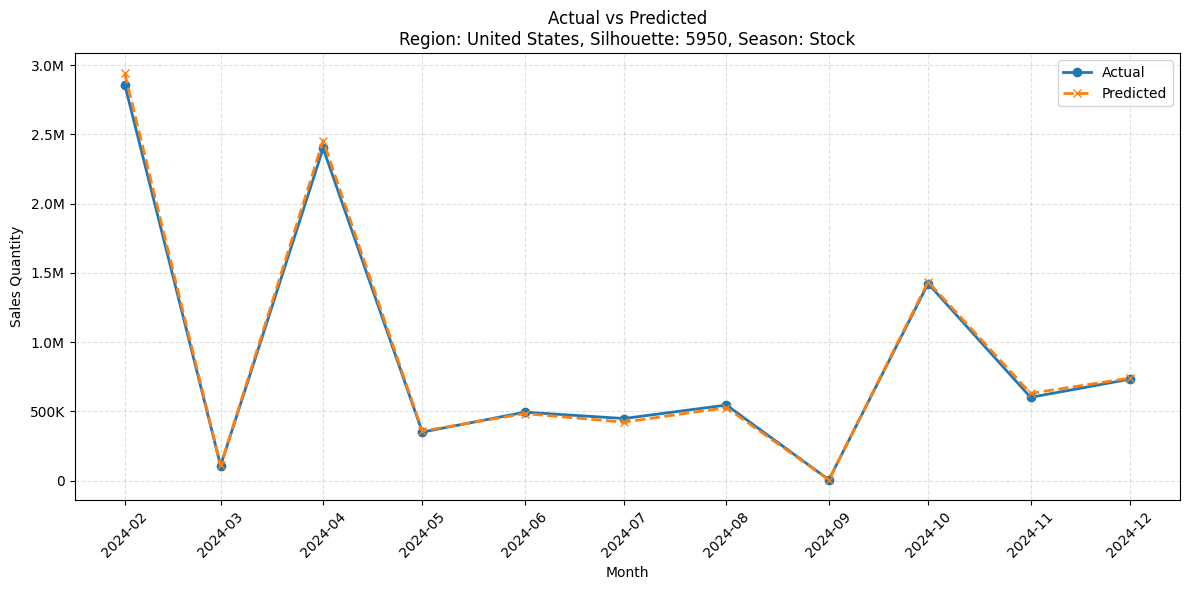

In [126]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- formatter ---
def thousands_formatter(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{int(x)}'

# -------------------------------------------------------
# 1. Build base DF
# -------------------------------------------------------

plot_df = test[['PO_CREATED_DATE', 
                'SALES_ORG_NAME', 
                'SILHOUETTE',
                'SEASON_CONSOLIDATION']].copy()

plot_df['actual'] = y_test.values
plot_df['pred'] = y_pred

# -------------------------------------------------------
# 2. CHOOSE FILTERS HERE
# -------------------------------------------------------

chosen_region = "United States"
chosen_silhouette = "5950"      # <-- change to your value
chosen_season = "Stock"        # <-- change to your value

# Apply filters (optional filters allowed)
filtered_df = plot_df.copy()

if chosen_region:
    filtered_df = filtered_df[filtered_df['SALES_ORG_NAME'] == chosen_region]
if chosen_silhouette:
    filtered_df = filtered_df[filtered_df['SILHOUETTE'] == chosen_silhouette]
if chosen_season:
    filtered_df = filtered_df[filtered_df['SEASON_CONSOLIDATION'] == chosen_season]

# -------------------------------------------------------
# 3. Aggregate after filtering
# -------------------------------------------------------

agg = filtered_df.groupby(['PO_CREATED_DATE'], as_index=False)[['actual','pred']].sum()

# -------------------------------------------------------
# 4. Plot
# -------------------------------------------------------

plt.figure(figsize=(12,6))

plt.plot(agg['PO_CREATED_DATE'], agg['actual'],
         marker='o', linewidth=2,
         label='Actual')

plt.plot(agg['PO_CREATED_DATE'], agg['pred'],
         marker='x', linestyle='--', linewidth=2,
         label='Predicted')

title_text = f"Actual vs Predicted\nRegion: {chosen_region}, Silhouette: {chosen_silhouette}, Season: {chosen_season}"
plt.title(title_text)

plt.xlabel('Month')
plt.ylabel('Sales Quantity')
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


# Model Training - Global


In [16]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [134]:
df_main['SILHOUETTE'].unique()

array(['5950', '3930'], dtype=object)

In [127]:
df_main.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,236
1,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,236
2,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,36
3,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,236
4,2009-01-05,EMEA,Other,NONE,5950,NONE,Headwear,Custom,36


In [132]:
# =====================================================
# 1) BASE PREP
# =====================================================

df = df_main.copy()

# Robust datetime conversion: assume PO_CREATED_DATE is key like 20240205
#df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'])

# Sort by date (important for lags)
df['PO_CREATED_DATE'] = pd.to_datetime(df['PO_CREATED_DATE'], format='%Y%m%d')\
                        .dt.to_period('M').dt.to_timestamp()
df = df[df['PO_CREATED_DATE'] >= '2009-01-01']
df = df.sort_values('PO_CREATED_DATE')

In [133]:
df.head()

,PO_CREATED_DATE,SALES_ORG_NAME,FABRIC_TYPE,TEAM,SILHOUETTE,SPORT,DIVISION_NAME,SEASON_CONSOLIDATION,ORDERED_QUANTITY
0,2009-01-01,EMEA,Other,NONE,5950,NONE,Headwear,Custom,236
1326,2009-01-01,United States,Wovens,NONE,5950,NONE,Headwear,Custom,2
1325,2009-01-01,United States,Wovens,NONE,5950,NONE,Headwear,Custom,30
1324,2009-01-01,United States,Wovens,NONE,5950,NONE,Headwear,Custom,72
1323,2009-01-01,United States,Wovens,NONE,5950,NONE,Headwear,Custom,30


In [135]:
# =====================================================
# 2) GROUP TO DESIRED GRANULARITY
# =====================================================

df = df.drop(columns=['FABRIC_TYPE','TEAM','SPORT','DIVISION_NAME'])

# categorical features

'''
group_cols_1 = [
    'PO_CREATED_DATE',
    'SALES_ORG_NAME',
    'FABRIC_TYPE',
    'TEAM',
    'DIVISION_NAME',
    'SPORT',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]
'''
group_cols_1 = [
    'PO_CREATED_DATE',
    'SALES_ORG_NAME', 
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]

#group_cols_2=['PO_CREATED_DATE','REGION','DIVISION_NAME','SPORT', 'GENDER']

df_grouped =(
    df.groupby(group_cols_1)['ORDERED_QUANTITY']
    .sum()
    .reset_index()   
) 

In [136]:
# =====================================================
# 3) LAG & ROLLING FEATURES
# =====================================================

# Make sure date is datetime (already done above, but keep consistent)
df_grouped['PO_CREATED_DATE'] = pd.to_datetime(df_grouped['PO_CREATED_DATE'])

# Sort by group keys + date (critical for correct lags)
'''
lag_groups = [
    'SALES_ORG_NAME',
    'FABRIC_TYPE',
    'TEAM',
    'DIVISION_NAME',
    'SPORT',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]
'''
lag_groups = [
    'SALES_ORG_NAME',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]

df_grouped = df_grouped.sort_values(lag_groups + ['PO_CREATED_DATE'])

# Lag features
for lag in [1, 2, 3, 6, 12]:
    df_grouped[f'lag_{lag}'] = (
        df_grouped
        .groupby(lag_groups, dropna=False)['ORDERED_QUANTITY']
        .shift(lag)
    )

# Rolling means (use min_periods=1 so early rows aren’t all NaN)
for window in [3, 6, 12]:
    df_grouped[f'rollmean_{window}'] = (
        df_grouped
        .groupby(lag_groups, dropna=False)['ORDERED_QUANTITY']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )

In [137]:
print(df_grouped['PO_CREATED_DATE'].min(), df_grouped['PO_CREATED_DATE'].max())
print(train.shape)
print(test.shape)


2009-01-01 00:00:00 2025-11-01 00:00:00
(5616, 18)
(413, 18)


In [139]:
# =====================================================
# 4) SEASONALITY FEATURES
# =====================================================

df_grouped['month'] = df_grouped['PO_CREATED_DATE'].dt.month
df_grouped['month_sin'] = np.sin(2 * np.pi * df_grouped['month'] / 12)
df_grouped['month_cos'] = np.cos(2 * np.pi * df_grouped['month'] / 12)
df_grouped['quarter'] = df_grouped['PO_CREATED_DATE'].dt.quarter

# =====================================================
# 5) HANDLE MISSING VALUES
# =====================================================

# Categorical NaNs → "Unknown"
'''
cat_cols_all = [
    'SALES_ORG_NAME', 'FABRIC_TYPE', 'TEAM', 'SEASON_CONSOLIDATION',
    'DIVISION_NAME', 'SPORT', 'SILHOUETTE'
]
'''
cat_cols_all = ['SALES_ORG_NAME','SEASON_CONSOLIDATION', 
                'SILHOUETTE'
            ]

df_grouped[cat_cols_all] = df_grouped[cat_cols_all].fillna('Unknown')

# Numeric NaNs: only lags & rolling features
lag_roll_cols = [c for c in df_grouped.columns if c.startswith('lag_') or c.startswith('rollmean_')]
df_grouped[lag_roll_cols] = df_grouped[lag_roll_cols].fillna(0)

# Target in log scale
df_grouped['ORDERED_QUANTITY_log'] = np.log1p(df_grouped['ORDERED_QUANTITY'])

In [140]:
print(df_grouped['PO_CREATED_DATE'].min(), df_grouped['PO_CREATED_DATE'].max())
print(train.shape)
print(test.shape)


2009-01-01 00:00:00 2025-11-01 00:00:00
(5616, 18)
(413, 18)


In [141]:
# =====================================================
# 6) TRAIN–TEST SPLIT (TIME-BASED)
# =====================================================

cutoff_train = pd.Timestamp('2024-01-01')
cutoff_test_end = pd.Timestamp('2025-01-01')

train = df_grouped[df_grouped['PO_CREATED_DATE'] < cutoff_train]
test  = df_grouped[(df_grouped['PO_CREATED_DATE'] >= cutoff_train) &
                   (df_grouped['PO_CREATED_DATE'] < cutoff_test_end)]

# Features / target
drop_cols = ['ORDERED_QUANTITY', 'ORDERED_QUANTITY_log', 'PO_CREATED_DATE']

X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY_log']

X_test  = test.drop(columns=drop_cols)
y_test  = np.expm1(test['ORDERED_QUANTITY_log'])  # back to original scale for metrics

# (Columns should match naturally; no reindex needed if built from same df_grouped)
assert list(X_train.columns) == list(X_test.columns), "Train/Test columns mismatch!"

# =====================================================
# 7) ENCODE CATEGORICALS (ORDINAL FOR LGBM)
# =====================================================

cat_cols = X_train.select_dtypes(include='object').columns

for col in cat_cols:
    # Fit categories on train
    X_train[col] = X_train[col].astype('category')
    categories = X_train[col].cat.categories

    # Apply same categories to test
    X_test[col] = pd.Categorical(X_test[col], categories=categories)

    # Convert to integer codes
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

    # Unknown / missing → -1
    X_test[col] = X_test[col].fillna(-1).astype(int)

In [142]:
# =====================================================
# 8) TRAIN LIGHTGBM MODEL
# =====================================================

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.075,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

# =====================================================
# 9) PREDICT & INVERSE TRANSFORM
# =====================================================

y_pred_log = model.predict(X_test)
# Safety cap to avoid insane log predictions
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=15)  # ~exp(15) ≈ 3.3M
y_pred = np.expm1(y_pred_log)

In [146]:
# Filter 2025 data from monthly aggregated df_grouped
test_2025 = df_grouped[
    (df_grouped['PO_CREATED_DATE'] >= '2025-01-01') &
    (df_grouped['PO_CREATED_DATE'] <= '2025-11-01')
].copy()


In [156]:
test_2025.head()

,PO_CREATED_DATE,SALES_ORG_NAME,SEASON_CONSOLIDATION,SILHOUETTE,ORDERED_QUANTITY,lag_1,lag_2,lag_3,lag_6,lag_12,rollmean_3,rollmean_6,rollmean_12,month,month_sin,month_cos,quarter,ORDERED_QUANTITY_log,Year,Month
6066,2025-01-01,Australia,Custom,3930,4848,810.0,1228.0,1008.0,252.0,5760.0,2295.333333,1704.500000,1379.416667,1,5.000000e-01,0.866025,1,8.486528,2025,1
6185,2025-04-01,Australia,Custom,3930,4824,4848.0,810.0,1228.0,2133.0,324.0,3494.000000,2153.000000,1754.416667,4,8.660254e-01,-0.500000,2,8.481566,2025,4
6272,2025-06-01,Australia,Custom,3930,576,4824.0,4848.0,810.0,200.0,870.0,3416.000000,2215.666667,1729.916667,6,1.224647e-16,-1.000000,2,6.357842,2025,6
6310,2025-07-01,Australia,Custom,3930,216,576.0,4824.0,4848.0,1008.0,2376.0,1872.000000,2083.666667,1549.916667,7,-5.000000e-01,-0.866025,3,5.379897,2025,7
6349,2025-08-01,Australia,Custom,3930,162,216.0,576.0,4824.0,1228.0,636.0,318.000000,1906.000000,1510.416667,8,-8.660254e-01,-0.500000,3,5.093750,2025,8


In [147]:
# Build X_test_2025 using same predictors as training set
X_test_2025 = test_2025.drop(columns=['ORDERED_QUANTITY', 'PO_CREATED_DATE'])

# Align columns exactly with X_train
X_test_2025 = X_test_2025.reindex(columns=X_train.columns, fill_value=0)

# True values (for evaluation later)
y_test_2025 = test_2025['ORDERED_QUANTITY']


In [153]:
cat_cols = ['SALES_ORG_NAME', 'SEASON_CONSOLIDATION', 'SILHOUETTE']

for col in cat_cols:
    # Convert train categories
    categories = X_train[col].astype('category').cat.categories
    
    # Apply same categories to 2025 test
    X_test_2025[col] = pd.Categorical(X_test_2025[col], categories=categories)
    X_test_2025[col] = X_test_2025[col].cat.codes
    X_test_2025[col] = X_test_2025[col].fillna(-1).astype(int)


In [167]:
y_pred_2025_log = model.predict(X_test_2025)
#y_pred_2025_log = np.clip(y_pred_2025_log, a_min=None, a_max=15)
#y_pred_2025 = np.expm1(y_pred_2025_log)


In [ ]:
df_pred_2025 = pd.DataFrame({
    'YearMonth': test_2025['PO_CREATED_DATE'].values,
    'Actual_2025': y_test_2025.values,
    'Pred_2025': y_pred_2025x``
})


In [166]:
# Choose filters
chosen_region = "United States"
chosen_silhouette = "5950"
chosen_season = "Custom"

df_plot_2025 = df_pred_2025.copy()

# Apply filters
if chosen_region:
    df_plot_2025 = df_plot_2025[df_plot_2025['SALES_ORG_NAME'] == chosen_region]

if chosen_silhouette:
    df_plot_2025 = df_plot_2025[df_plot_2025['SILHOUETTE'] == chosen_silhouette]

if chosen_season:
    df_plot_2025 = df_plot_2025[df_plot_2025['SEASON_CONSOLIDATION'] == chosen_season]

# Aggregate monthly AFTER filtering
df_plot_2025 = df_plot_2025.groupby('YearMonth', as_index=False)[['Actual_2025','Pred_2025']].sum()


KeyError: 'SALES_ORG_NAME'

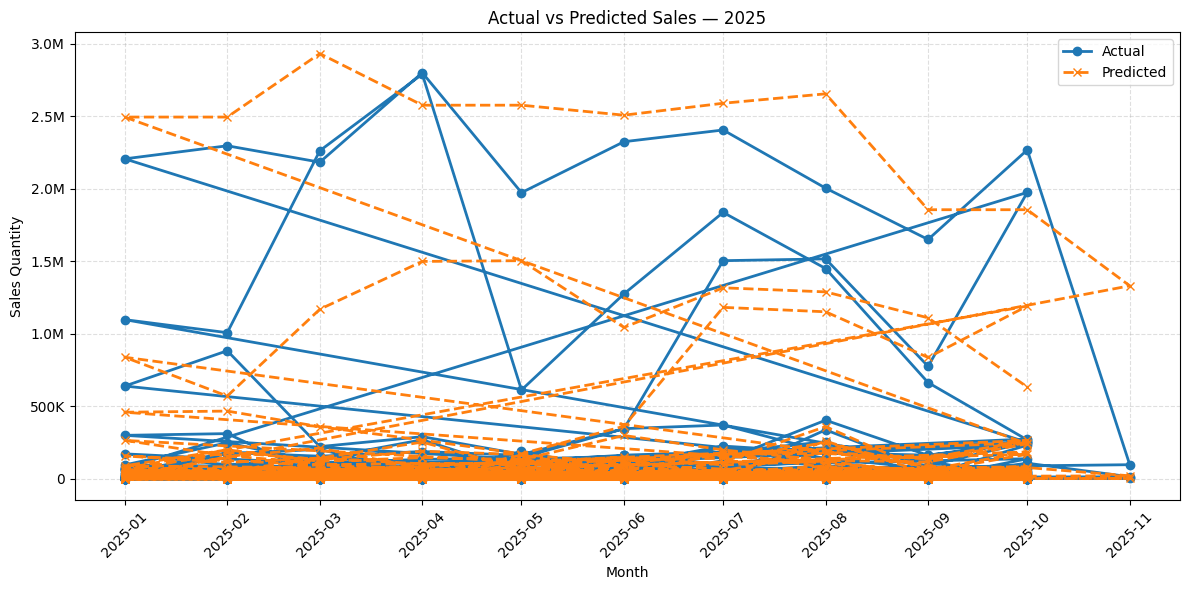

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    if x >= 1_000_000:
        return f'{x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'{x/1_000:.0f}K'
    else:
        return f'{int(x)}'

plt.figure(figsize=(12,6))

plt.plot(df_plot_2025['YearMonth'], df_plot_2025['Actual_2025'],
         marker='o', linewidth=2, label='Actual')

plt.plot(df_plot_2025['YearMonth'], df_plot_2025['Pred_2025'],
         marker='x', linestyle='--', linewidth=2, label='Predicted')

plt.title(f"Actual vs Predicted — 2025\nRegion: {chosen_region}, Silhouette: {chosen_silhouette}, Season: {chosen_season}")
plt.xlabel("Month")
plt.ylabel("Sales Quantity")
plt.grid(True, alpha=0.4)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [143]:
# =====================================================
# 10) EVALUATE
# =====================================================

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nModel Performance (Global PO Model):")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"WAPE  : {wape*100:.2f}%")
print(f"MAPE  : {mape:.2f}%")
print(f"Mean Ordered Qty: {y_test.mean():,.2f}")
print(f"Approx. Accuracy (1 - WAPE): {100 - (wape*100):.2f}%")



Model Performance (Global PO Model):
MAE   : 42,338.21
RMSE  : 186,846.40
WAPE  : 27.86%
MAPE  : 802.15%
Mean Ordered Qty: 151,958.67
Approx. Accuracy (1 - WAPE): 72.14%


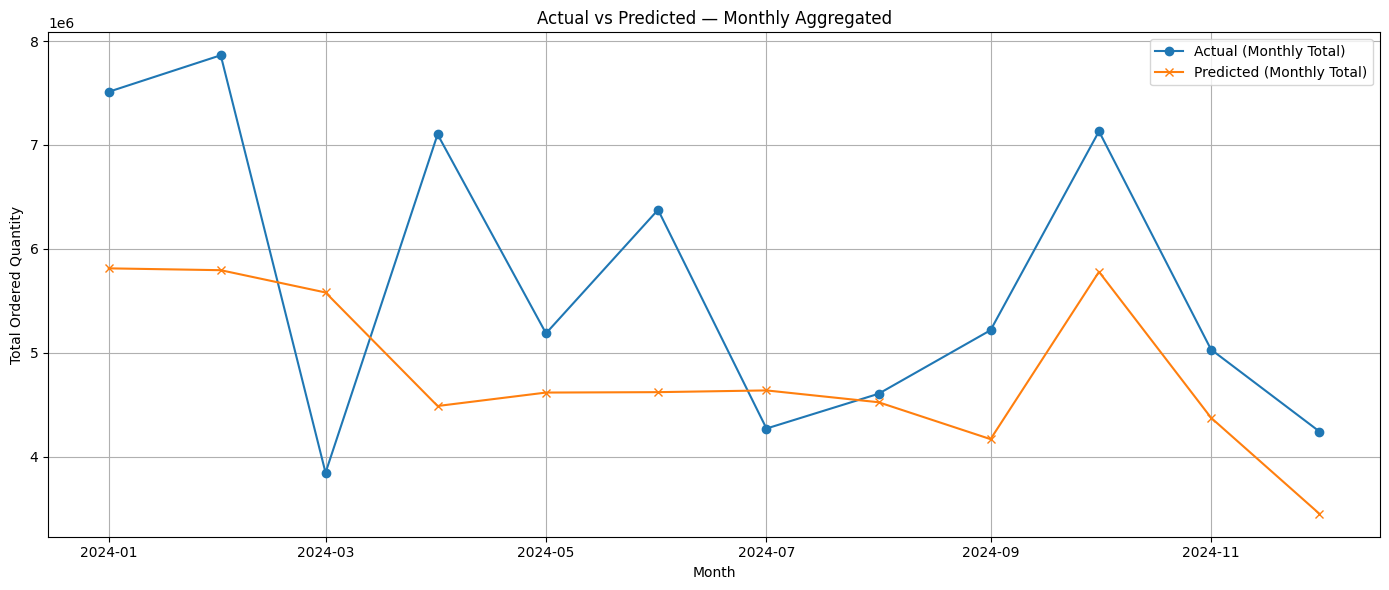

In [144]:
plot_df = test[['PO_CREATED_DATE']].copy()
plot_df['actual'] = y_test.values
plot_df['pred'] = y_pred

# Convert to month period and aggregate
plot_df['month'] = plot_df['PO_CREATED_DATE'].dt.to_period('M')

agg = plot_df.groupby('month')[['actual', 'pred']].sum().reset_index()
agg['month'] = agg['month'].dt.to_timestamp()

plt.figure(figsize=(14, 6))
plt.plot(agg['month'], agg['actual'], marker='o', label='Actual (Monthly Total)')
plt.plot(agg['month'], agg['pred'], marker='x', label='Predicted (Monthly Total)')

plt.title("Actual vs Predicted — Monthly Aggregated")
plt.xlabel("Month")
plt.ylabel("Total Ordered Quantity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 5950

In [46]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# =====================================================
# 1) BASE PREP
# =====================================================

df = df_main.copy()

# Sort by date (important for lags)
df = df[df['PO_CREATED_DATE'] >= '2009-01-01']
df = df.sort_values('PO_CREATED_DATE')


In [47]:
df = df[df['SILHOUETTE'] == '5950']

In [48]:
# =====================================================
# 2) GROUP TO DESIRED GRANULARITY
# =====================================================

group_cols_1 = [
    'PO_CREATED_DATE',
    'SALES_ORG_NAME',
    'FABRIC_TYPE',
    'TEAM',
    'DIVISION_NAME',
    'SPORT',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]

df_grouped = (
    df.groupby(group_cols_1, dropna=False)['ORDERED_QUANTITY']
      .sum()
      .reset_index()
)

# Optional: capping (uncomment if needed)
# train_mask_tmp = df_grouped['PO_CREATED_DATE'] < pd.Timestamp('2024-01-01')
# cap_q = 0.998
# cap = df_grouped.loc[train_mask_tmp, 'ORDERED_QUANTITY'].quantile(cap_q)
# df_grouped.loc[train_mask_tmp, 'ORDERED_QUANTITY'] = \
#     df_grouped.loc[train_mask_tmp, 'ORDERED_QUANTITY'].clip(upper=cap)

# =====================================================
# 3) LAG & ROLLING FEATURES
# =====================================================

# Make sure date is datetime (already done above, but keep consistent)
df_grouped['PO_CREATED_DATE'] = pd.to_datetime(df_grouped['PO_CREATED_DATE'])

# Sort by group keys + date (critical for correct lags)
lag_groups = [
    'SALES_ORG_NAME',
    'FABRIC_TYPE',
    'TEAM',
    'DIVISION_NAME',
    'SPORT',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]

df_grouped = df_grouped.sort_values(lag_groups + ['PO_CREATED_DATE'])

# Lag features
for lag in [1, 2, 3, 6, 12]:
    df_grouped[f'lag_{lag}'] = (
        df_grouped
        .groupby(lag_groups, dropna=False)['ORDERED_QUANTITY']
        .shift(lag)
    )

# Rolling means (use min_periods=1 so early rows aren’t all NaN)
for window in [3, 6, 12]:
    df_grouped[f'rollmean_{window}'] = (
        df_grouped
        .groupby(lag_groups, dropna=False)['ORDERED_QUANTITY']
        .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    )

# =====================================================
# 4) SEASONALITY FEATURES
# =====================================================

df_grouped['month'] = df_grouped['PO_CREATED_DATE'].dt.month
df_grouped['month_sin'] = np.sin(2 * np.pi * df_grouped['month'] / 12)
df_grouped['month_cos'] = np.cos(2 * np.pi * df_grouped['month'] / 12)
df_grouped['quarter'] = df_grouped['PO_CREATED_DATE'].dt.quarter

# =====================================================
# 5) HANDLE MISSING VALUES
# =====================================================

# Categorical NaNs → "Unknown"
cat_cols_all = [
    'SALES_ORG_NAME', 'FABRIC_TYPE', 'TEAM', 'SEASON_CONSOLIDATION',
    'DIVISION_NAME', 'SPORT', 'SILHOUETTE'
]
df_grouped[cat_cols_all] = df_grouped[cat_cols_all].fillna('Unknown')

# Numeric NaNs: only lags & rolling features
lag_roll_cols = [c for c in df_grouped.columns if c.startswith('lag_') or c.startswith('rollmean_')]
df_grouped[lag_roll_cols] = df_grouped[lag_roll_cols].fillna(0)

# Target in log scale
df_grouped['ORDERED_QUANTITY_log'] = np.log1p(df_grouped['ORDERED_QUANTITY'])

# =====================================================
# 6) TRAIN–TEST SPLIT (TIME-BASED)
# =====================================================

cutoff_train = pd.Timestamp('2024-01-01')
cutoff_test_end = pd.Timestamp('2025-01-01')

train = df_grouped[df_grouped['PO_CREATED_DATE'] < cutoff_train]
test  = df_grouped[(df_grouped['PO_CREATED_DATE'] >= cutoff_train) &
                   (df_grouped['PO_CREATED_DATE'] < cutoff_test_end)]

# Features / target
drop_cols = ['ORDERED_QUANTITY', 'ORDERED_QUANTITY_log', 'PO_CREATED_DATE']

X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY_log']

X_test  = test.drop(columns=drop_cols)
y_test  = np.expm1(test['ORDERED_QUANTITY_log'])  # back to original scale for metrics

# (Columns should match naturally; no reindex needed if built from same df_grouped)
assert list(X_train.columns) == list(X_test.columns), "Train/Test columns mismatch!"

# =====================================================
# 7) ENCODE CATEGORICALS (ORDINAL FOR LGBM)
# =====================================================

cat_cols = X_train.select_dtypes(include='object').columns

for col in cat_cols:
    # Fit categories on train
    X_train[col] = X_train[col].astype('category')
    categories = X_train[col].cat.categories

    # Apply same categories to test
    X_test[col] = pd.Categorical(X_test[col], categories=categories)

    # Convert to integer codes
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

    # Unknown / missing → -1
    X_test[col] = X_test[col].fillna(-1).astype(int)

# =====================================================
# 8) TRAIN LIGHTGBM MODEL
# =====================================================

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.075,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

# =====================================================
# 9) PREDICT & INVERSE TRANSFORM
# =====================================================

y_pred_log = model.predict(X_test)
# Safety cap to avoid insane log predictions
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=15)  # ~exp(15) ≈ 3.3M
y_pred = np.expm1(y_pred_log)

# =====================================================
# 10) EVALUATE
# =====================================================

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nModel Performance (Global PO Model):")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"WAPE  : {wape*100:.2f}%")
print(f"MAPE  : {mape:.2f}%")
print(f"Mean Ordered Qty: {y_test.mean():,.2f}")
print(f"Approx. Accuracy (1 - WAPE): {100 - (wape*100):.2f}%")



Model Performance (Global PO Model):
MAE   : 1,365.02
RMSE  : 10,719.59
WAPE  : 44.86%
MAPE  : 765.13%
Mean Ordered Qty: 3,042.95
Approx. Accuracy (1 - WAPE): 55.14%


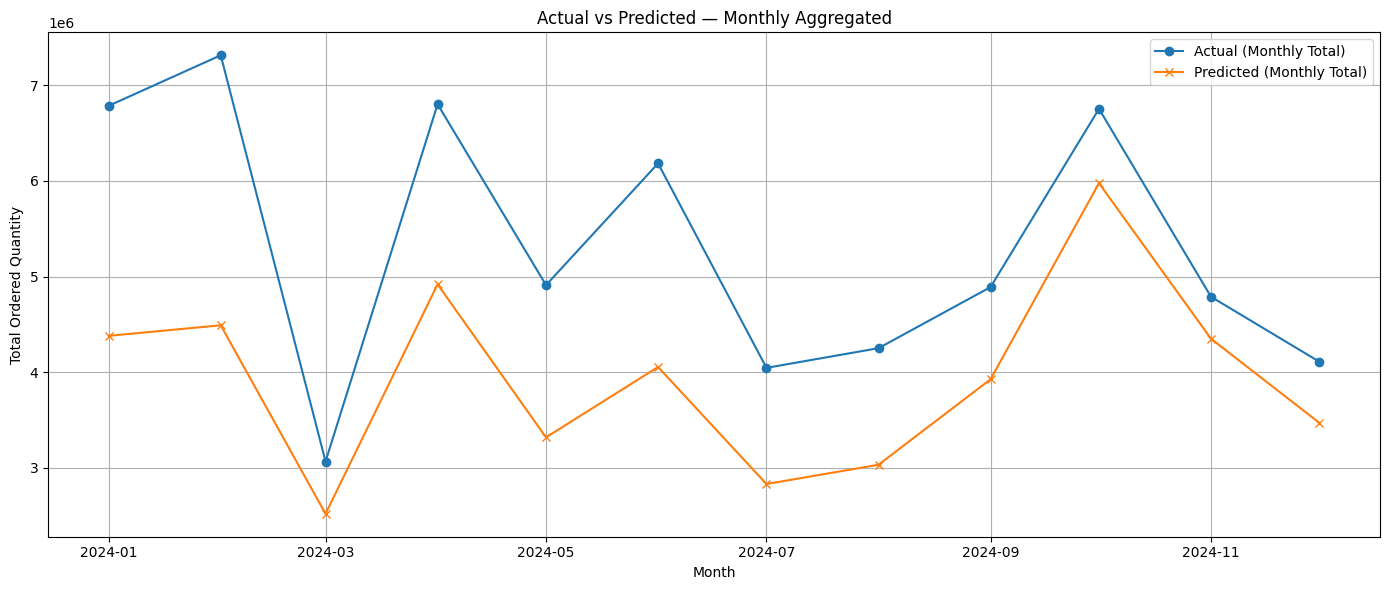

In [49]:
plot_df = test[['PO_CREATED_DATE']].copy()
plot_df['actual'] = y_test.values
plot_df['pred'] = y_pred

# Convert to month period and aggregate
plot_df['month'] = plot_df['PO_CREATED_DATE'].dt.to_period('M')

agg = plot_df.groupby('month')[['actual', 'pred']].sum().reset_index()
agg['month'] = agg['month'].dt.to_timestamp()

plt.figure(figsize=(14, 6))
plt.plot(agg['month'], agg['actual'], marker='o', label='Actual (Monthly Total)')
plt.plot(agg['month'], agg['pred'], marker='x', label='Predicted (Monthly Total)')

plt.title("Actual vs Predicted — Monthly Aggregated")
plt.xlabel("Month")
plt.ylabel("Total Ordered Quantity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# US

In [50]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# =====================================================
# 1) BASE PREP
# =====================================================

df = df_main.copy()

# Sort by date (important for lags)
df = df[df['PO_CREATED_DATE'] >= '2009-01-01']
df = df.sort_values('PO_CREATED_DATE')


In [51]:
df = df[df['SALES_ORG_NAME'] == 'United States']

In [55]:
# =====================================================
# 2) GROUP TO DESIRED GRANULARITY
# =====================================================

group_cols_1 = [
    'PO_CREATED_DATE',
    'SALES_ORG_NAME',
    'FABRIC_TYPE',
    'TEAM',
    'DIVISION_NAME',
    'SPORT',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]

df_grouped = (
    df.groupby(group_cols_1, dropna=False)['ORDERED_QUANTITY']
      .sum()
      .reset_index()
)

# Optional: capping (uncomment if needed)
# train_mask_tmp = df_grouped['PO_CREATED_DATE'] < pd.Timestamp('2024-01-01')
# cap_q = 0.998
# cap = df_grouped.loc[train_mask_tmp, 'ORDERED_QUANTITY'].quantile(cap_q)
# df_grouped.loc[train_mask_tmp, 'ORDERED_QUANTITY'] = \
#     df_grouped.loc[train_mask_tmp, 'ORDERED_QUANTITY'].clip(upper=cap)

# =====================================================
# 3) LAG & ROLLING FEATURES
# =====================================================

# Make sure date is datetime (already done above, but keep consistent)
df_grouped['PO_CREATED_DATE'] = pd.to_datetime(df_grouped['PO_CREATED_DATE'])

# Sort by group keys + date (critical for correct lags)
lag_groups = [
    'SALES_ORG_NAME',
    'FABRIC_TYPE',
    'TEAM',
    'DIVISION_NAME',
    'SPORT',
    'SEASON_CONSOLIDATION',
    'SILHOUETTE'
]

df_grouped = df_grouped.sort_values(lag_groups + ['PO_CREATED_DATE'])

# Lag features
for lag in [1, 2, 3, 6, 12]:
    df_grouped[f'lag_{lag}'] = (
        df_grouped
        .groupby(lag_groups, dropna=False)['ORDERED_QUANTITY']
        .shift(lag)
    )

# Rolling means (use min_periods=1 so early rows aren’t all NaN)
for window in [3, 6, 12]:
    df_grouped[f'rollmean_{window}'] = (
        df_grouped
        .groupby(lag_groups, dropna=False)['ORDERED_QUANTITY']
        .transform(
            lambda x: x.rolling(window=window, min_periods=1).mean().shift(1)
        )
    )


# =====================================================
# 4) SEASONALITY FEATURES
# =====================================================

df_grouped['month'] = df_grouped['PO_CREATED_DATE'].dt.month
df_grouped['month_sin'] = np.sin(2 * np.pi * df_grouped['month'] / 12)
df_grouped['month_cos'] = np.cos(2 * np.pi * df_grouped['month'] / 12)
df_grouped['quarter'] = df_grouped['PO_CREATED_DATE'].dt.quarter

# =====================================================
# 5) HANDLE MISSING VALUES
# =====================================================

# Categorical NaNs → "Unknown"
cat_cols_all = [
    'SALES_ORG_NAME', 'FABRIC_TYPE', 'TEAM', 'SEASON_CONSOLIDATION',
    'DIVISION_NAME', 'SPORT', 'SILHOUETTE'
]
df_grouped[cat_cols_all] = df_grouped[cat_cols_all].fillna('Unknown')

# Numeric NaNs: only lags & rolling features
lag_roll_cols = [c for c in df_grouped.columns if c.startswith('lag_') or c.startswith('rollmean_')]
df_grouped[lag_roll_cols] = df_grouped[lag_roll_cols].fillna(0)

# Target in log scale
df_grouped['ORDERED_QUANTITY_log'] = np.log1p(df_grouped['ORDERED_QUANTITY'])

# =====================================================
# 6) TRAIN–TEST SPLIT (TIME-BASED)
# =====================================================

cutoff_train = pd.Timestamp('2024-01-01')
cutoff_test_end = pd.Timestamp('2025-01-01')

train = df_grouped[df_grouped['PO_CREATED_DATE'] < cutoff_train]
test  = df_grouped[(df_grouped['PO_CREATED_DATE'] >= cutoff_train) &
                   (df_grouped['PO_CREATED_DATE'] < cutoff_test_end)]

# Features / target
drop_cols = ['ORDERED_QUANTITY', 'ORDERED_QUANTITY_log', 'PO_CREATED_DATE']

X_train = train.drop(columns=drop_cols)
y_train = train['ORDERED_QUANTITY_log']

X_test  = test.drop(columns=drop_cols)
y_test  = np.expm1(test['ORDERED_QUANTITY_log'])  # back to original scale for metrics

# (Columns should match naturally; no reindex needed if built from same df_grouped)
assert list(X_train.columns) == list(X_test.columns), "Train/Test columns mismatch!"

# =====================================================
# 7) ENCODE CATEGORICALS (ORDINAL FOR LGBM)
# =====================================================

cat_cols = X_train.select_dtypes(include='object').columns

for col in cat_cols:
    # Fit categories on train
    X_train[col] = X_train[col].astype('category')
    categories = X_train[col].cat.categories

    # Apply same categories to test
    X_test[col] = pd.Categorical(X_test[col], categories=categories)

    # Convert to integer codes
    X_train[col] = X_train[col].cat.codes
    X_test[col] = X_test[col].cat.codes

    # Unknown / missing → -1
    X_test[col] = X_test[col].fillna(-1).astype(int)

# =====================================================
# 8) TRAIN LIGHTGBM MODEL
# =====================================================

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.075,
    'num_leaves': 31,
    'verbose': -1
}

model = lgb.LGBMRegressor(**params)
model.fit(X_train, y_train)

# =====================================================
# 9) PREDICT & INVERSE TRANSFORM
# =====================================================

y_pred_log = model.predict(X_test)
# Safety cap to avoid insane log predictions
y_pred_log = np.clip(y_pred_log, a_min=None, a_max=15)  # ~exp(15) ≈ 3.3M
y_pred = np.expm1(y_pred_log)

# =====================================================
# 10) EVALUATE
# =====================================================

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
wape = np.sum(np.abs(y_test - y_pred)) / np.sum(y_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nModel Performance (Global PO Model):")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"WAPE  : {wape*100:.2f}%")
print(f"MAPE  : {mape:.2f}%")
print(f"Mean Ordered Qty: {y_test.mean():,.2f}")
print(f"Approx. Accuracy (1 - WAPE): {100 - (wape*100):.2f}%")


Model Performance (Global PO Model):
MAE   : 1,017.41
RMSE  : 7,424.06
WAPE  : 90.83%
MAPE  : 2622.78%
Mean Ordered Qty: 1,120.14
Approx. Accuracy (1 - WAPE): 9.17%


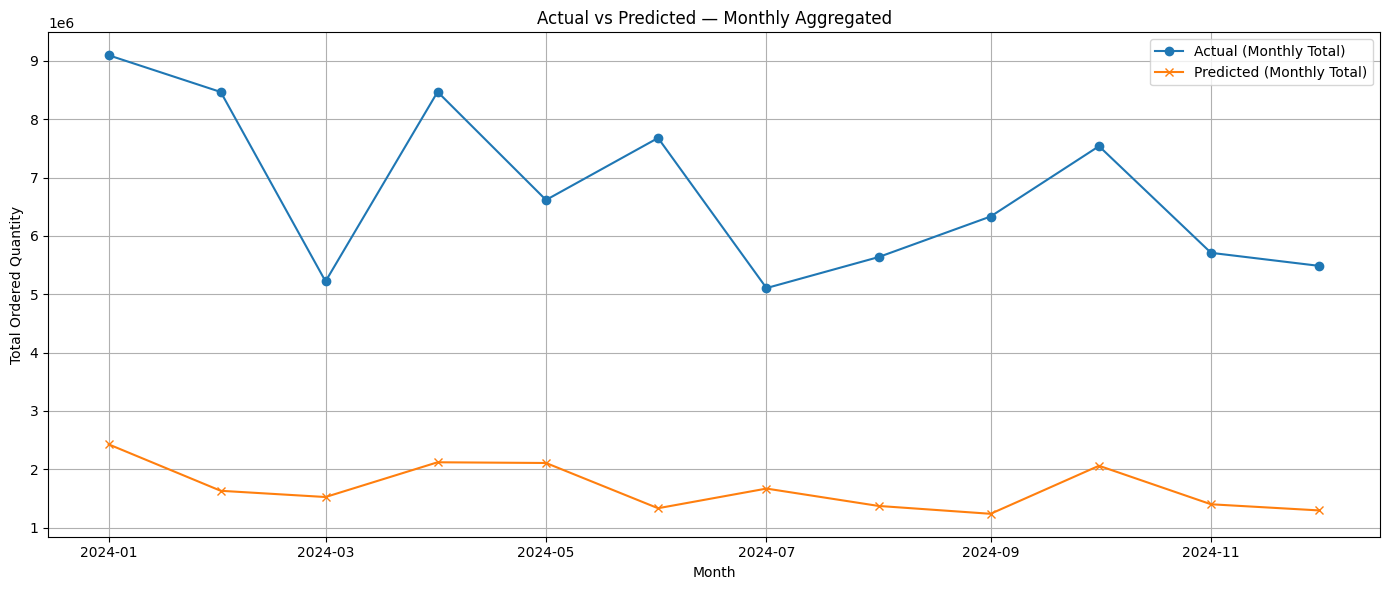

In [56]:
plot_df = test[['PO_CREATED_DATE']].copy()
plot_df['actual'] = y_test.values
plot_df['pred'] = y_pred

# Convert to month period and aggregate
plot_df['month'] = plot_df['PO_CREATED_DATE'].dt.to_period('M')

agg = plot_df.groupby('month')[['actual', 'pred']].sum().reset_index()
agg['month'] = agg['month'].dt.to_timestamp()

plt.figure(figsize=(14, 6))
plt.plot(agg['month'], agg['actual'], marker='o', label='Actual (Monthly Total)')
plt.plot(agg['month'], agg['pred'], marker='x', label='Predicted (Monthly Total)')

plt.title("Actual vs Predicted — Monthly Aggregated")
plt.xlabel("Month")
plt.ylabel("Total Ordered Quantity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
